In [1]:
import os,sys,inspect
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

In [2]:
from datetime import datetime

ovito_file_name = datetime.now().strftime("%Y_%m_%d-%I:%M:%S_%p")

def Save_partial_results(Kn_d_j,H,ftp_times_j,ftp_times_std_j,tau_12_j,Kn_g_j,
                              L_j,Rc_j,V_box,t_ij,A_j,k_BT,f_12_j,beta_j,
                        name="validation_spheres_with_vdw_diffusive"):
    results_exp = np.column_stack((Kn_d_j,H,ftp_times_j,ftp_times_std_j,tau_12_j,Kn_g_j,
                              L_j,Rc_j,V_box,t_ij,A_j/k_BT,f_12_j,beta_j))
    file_name = "RES_out/"+name+".dat"
    np.savetxt(file_name, results_exp, delimiter=",")
    return

def Export_current_sim(ftp_model,i,normalize=False):
    x1,y1,z1,r1 = ftp_model.Get_spheres(1)
    x2,y2,z2,r2 = ftp_model.Get_spheres(2)
    ofname = "ovito_out/" +ovito_file_name+".dump"
    radius = np.concatenate((r1, r2))
    if (normalize):
        nor_factor = np.mean(radius)
        radius = radius/nor_factor
    box_l = ftp_model.L_box/nor_factor
    box = ((-0.5*box_l,0.5*box_l),\
           (-0.5*box_l,0.5*box_l),\
           (-0.5*box_l,0.5*box_l))
    pos = np.array([np.concatenate((x1/nor_factor, x2/nor_factor)),
                   np.concatenate((y1/nor_factor, y2/nor_factor)),
                   np.concatenate((z1/nor_factor, z2/nor_factor))]).transpose()
    vel = pos *0
    
    N = len(x1)+len(x2)
    dump.writeOutput(ofname, N, i, box, radius=radius, pos=pos, v=vel)
    return

In [3]:
import dump
import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt

In [4]:
import Py_FTP_Langevin as ftp
import ftp_support

In [5]:
k_B = 1.38066e-23    #! Boltzmann constant in (J/K)
Na = 6.02214076 * pow(10,23) # 1/mol

In [6]:
fontsize_axis = 20
fontsize_legend = 16
fontsize_ticks = 14

# First time passage simulations

In [7]:
#//! *********** PARAMETERS PARTICLE PROPERTIES *********** !
MM,Rho_p,epsilon_lj,sigma_lj,_ = ftp_support.Get_params_particles("Soot")

sigma_lj = 0

#//! *********** SIMULATION PARAMETERS *********** !
N_runs = 300 #; 500
Box_L_factor_dmax = 80 #80 #; //! Box size as factor of D_p
T_g = 300. #;  1700          //! Fluid temperature
P_g = 101300. #;          //! Fluid pressure
phi_p = 0.01 / 100 #;   //! Particles number concentration (1000 ppm = 0.01)    
with_collisions = True
with_rel_motion = True
with_rotation = False
#factor_vdw , determined for each case

#//! *********** LANGEVIN PARAMETERS *********** !
run_taus_min = 120 #; // Keep in 100 to be accurate with LD theory (otherwise the 6*D*t is not strictly respected)
LD_dt_factor = 1e-01 #;

#//! *********** PARAMETERS INT. POTENTIALS *********** !
alpha_dp = 0.1 #0.01
alpha_dp_max = 0.1
direct = "aggregate_info";

In [8]:
model = ftp.Pymodel(direct)
model

In [9]:
Dp_all = np.logspace(np.log10(1),np.log10(1e+03),10) * (1e-09)
Dp = np.max(Dp_all)
#Dp = np.min(Dp_all)

k_BT = k_B * T_g
A = np.logspace(np.log10(0.5),np.log10(250),10) * k_BT
#A = np.logspace(np.log10(0.5),np.log10(250),3) * k_BT
A = np.append(np.array([0]),A)

In [10]:
# Potential well analysis
e_well_i = np.zeros_like(A)
r_e_well_i = np.zeros_like(A)
factor_vdw_i = np.zeros_like(A)

for i in range(len(A)):
    e_well,r_e_well = ftp_support.Determine_pot_well(Dp,Dp,A[i],sigma_lj,k_BT)
    e_well_i[i] = e_well
    r_e_well_i[i] = r_e_well
    factor_vdw_i[i] = r_e_well/(0.5*(Dp+Dp))

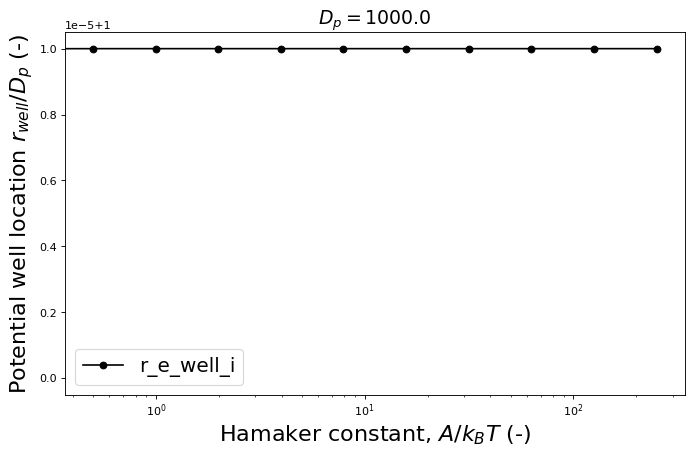

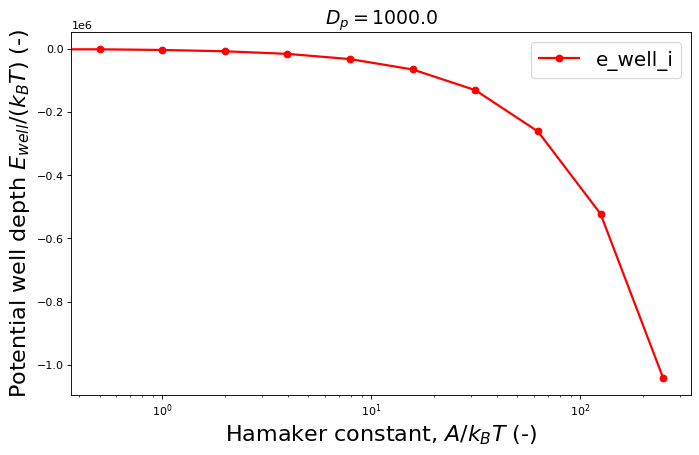

(<matplotlib.legend.Legend at 0x7fde2ac52350>, None)

In [11]:
fig, ax1 = plt.subplots(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
ax1.plot(A/k_BT,r_e_well_i/Dp,"o-k",label="r_e_well_i")
title = "$D_p=$"+str(round(Dp*1e+09,2))
plt.title(title,fontsize=17); plt.xscale("log")
ax1.set_ylabel('Potential well location $r_{well}/D_p$ (-)', fontsize=20)
ax1.set_xlabel('Hamaker constant, $A/k_BT$ (-)', fontsize=20)
plt.legend(fontsize=18, loc=0), plt.show()

fig, ax1 = plt.subplots(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
ax1.plot(A/k_BT,e_well_i,"o-r", linewidth=2,label="e_well_i")
#ax1.plot(Dp*1e+09,r_e_well_i/Dp,".-k",label="r_e_well_i")
plt.title(title,fontsize=17); plt.xscale("log")
ax1.set_ylabel('Potential well depth $E_{well}/(k_BT)$ (-)', fontsize=20)
ax1.set_xlabel('Hamaker constant, $A/k_BT$ (-)', fontsize=20)
plt.legend(fontsize=18, loc=0), plt.show()

In [12]:
r_e_well_i/Dp

array([1.     , 1.00001, 1.00001, 1.00001, 1.00001, 1.00001, 1.00001,
       1.00001, 1.00001, 1.00001, 1.00001])

In [13]:
ftp.Init_Random()
ftp.Make_output_folder()

In [14]:
files = ftp.get_dir_files(direct)
N_files = len(files)

In [15]:
def isNaN(num):
    if float('-inf') < float(num) < float('inf'):
        return False 
    else:
        return True

In [16]:
factor_vdw = 1

model.Set_prop(MM,Rho_p,N_runs,Box_L_factor_dmax,
               T_g,P_g,phi_p,run_taus_min,LD_dt_factor,
               A[0],sigma_lj,alpha_dp,alpha_dp_max,factor_vdw,Dp,
               with_collisions,with_rel_motion,with_rotation,direct)

ftp_model = ftp.PyFTP(model)

path_agg = direct + "/" + files[0].decode('utf-8')
print(path_agg)

aggregate_info/Agglomerate_N_000000001_Agg_00000001.dat


In [17]:
ftp_times_j = np.zeros(len(A))
ftp_times_std_j = np.zeros(len(A))
Kn_d_j = np.zeros(len(A))
Kn_g_j = np.zeros(len(A))
tau_12_j = np.zeros(len(A))
L_j = np.zeros(len(A))
Rc_j = np.zeros(len(A))
A_j = np.zeros(len(A))
f_12_j = np.zeros(len(A))
beta_j = np.zeros(len(A))
V_box = np.zeros(len(A))
t_ij = np.zeros(len(A))
H = np.zeros(len(A))

In [18]:
dt_vector = []
rel_dist = []

for j in tqdm(range(len(A))):
    #print("Analysis: ",j)
    factor_vdw = r_e_well_i[j]/Dp
    model.Set_prop(MM,Rho_p,N_runs,Box_L_factor_dmax,
               T_g,P_g,phi_p,run_taus_min,LD_dt_factor,
               A[j],sigma_lj,alpha_dp,alpha_dp_max,factor_vdw,Dp,
               with_collisions,with_rel_motion,with_rotation,direct)
    ftp_model.Load_aggregates_external(path_agg, model)
    ftp_times = np.asarray([])
    
    for k in range(N_runs):
        ftp_model.Restart_ftp(model)
        #ftp_model.show_spheres()
        ftp_model.Move_2_origin()
        ftp_model.Random_init_location()
        if (k == 0):
            #ftp.Show_parameters(spheres2, model)
            Export_current_sim(ftp_model,0,True)
        i=1
        it_exp = 1
        collision = False
        while(not collision):
            collision = ftp_model.run(model, 1)
            if(isNaN(ftp_model.t_res)):
                print("d_time ",ftp_model.d_time, " t_res ",ftp_model.t_res)
                break
            if((it_exp%1 == 0) and (k == 0)):
                Export_current_sim(ftp_model,it_exp,True)
                dt_vector = np.append(dt_vector, ftp_model.d_time)
                rel_dist = np.append(rel_dist, ftp_model.Relative_dist)
            it_exp += 1
        i += 1
        ftp_times = np.append(ftp_times, ftp_model.t_res)
    ftp_times_std_j[j] = np.std(ftp_times)
    ftp_times_j[j] = np.mean(ftp_times)
    tau_12_j[j] = ftp_model.Tau_ij
    f_12_j[j] = ftp_model.f_ij
    Kn_d_j[j] = ftp_model.Kn_d_ij
    Kn_g_j[j] = ftp_model.Kn_g_avg
    L_j[j] = ftp_model.L_box
    Rc_j[j] = ftp_model.Rc
    A_j[j] = A[j]
    V_box[j] = np.power(L_j[j],3)
    t_ij[j] = ftp_times_j[j]/tau_12_j[j]
    H[j] = V_box[j]/(np.power(Rc_j[j],3)*t_ij[j])
    m_12 = tau_12_j[j] * f_12_j[j]
    beta_j[j] = H[j] * f_12_j[j] * np.power(Rc_j[j], 3)/(m_12)
    Save_partial_results(Kn_d_j,
                         H,
                         ftp_times_j,
                         ftp_times_std_j,
                         tau_12_j,
                         Kn_g_j,
                         L_j,
                         Rc_j,
                         V_box,
                         t_ij,
                         A_j,
                         k_BT,
                         f_12_j,
                         beta_j)

  0%|                                                                  | 0/11 [00:00<?, ?it/s]

Collision detected (moving,static): (0 0); dist/(R_p1+R_p2)= 0.965278 factor_vdw: 1
Collision detected (moving,static): (0 0); dist/(R_p1+R_p2)= 0.86787 factor_vdw: 1
Collision detected (moving,static): (0 0); dist/(R_p1+R_p2)= 0.905673 factor_vdw: 1
Collision detected (moving,static): (0 0); dist/(R_p1+R_p2)= 0.851114 factor_vdw: 1
Collision detected (moving,static): (0 0); dist/(R_p1+R_p2)= 0.996294 factor_vdw: 1
Collision detected (moving,static): (0 0); dist/(R_p1+R_p2)= 0.91302 factor_vdw: 1
Collision detected (moving,static): (0 0); dist/(R_p1+R_p2)= 0.989715 factor_vdw: 1
Collision detected (moving,static): (0 0); dist/(R_p1+R_p2)= 0.979672 factor_vdw: 1
Collision detected (moving,static): (0 0); dist/(R_p1+R_p2)= 0.925347 factor_vdw: 1
Collision detected (moving,static): (0 0); dist/(R_p1+R_p2)= 0.935737 factor_vdw: 1
Collision detected (moving,static): (0 0); dist/(R_p1+R_p2)= 0.960851 factor_vdw: 1
Collision detected (moving,static): (0 0); dist/(R_p1+R_p2)= 0.859492 factor_v

Collision detected (moving,static): (0 0); dist/(R_p1+R_p2)= 0.862424 factor_vdw: 1
Collision detected (moving,static): (0 0); dist/(R_p1+R_p2)= 0.98093 factor_vdw: 1
Collision detected (moving,static): (0 0); dist/(R_p1+R_p2)= 0.913656 factor_vdw: 1
Collision detected (moving,static): (0 0); dist/(R_p1+R_p2)= 0.942329 factor_vdw: 1
Collision detected (moving,static): (0 0); dist/(R_p1+R_p2)= 0.900543 factor_vdw: 1
Collision detected (moving,static): (0 0); dist/(R_p1+R_p2)= 0.974874 factor_vdw: 1
Collision detected (moving,static): (0 0); dist/(R_p1+R_p2)= 0.951416 factor_vdw: 1
Collision detected (moving,static): (0 0); dist/(R_p1+R_p2)= 0.80275 factor_vdw: 1
Collision detected (moving,static): (0 0); dist/(R_p1+R_p2)= 0.942707 factor_vdw: 1
Collision detected (moving,static): (0 0); dist/(R_p1+R_p2)= 0.936553 factor_vdw: 1
Collision detected (moving,static): (0 0); dist/(R_p1+R_p2)= 0.892696 factor_vdw: 1
Collision detected (moving,static): (0 0); dist/(R_p1+R_p2)= 0.946314 factor_v

  0%|                                                                  | 0/11 [07:25<?, ?it/s]


KeyboardInterrupt: 

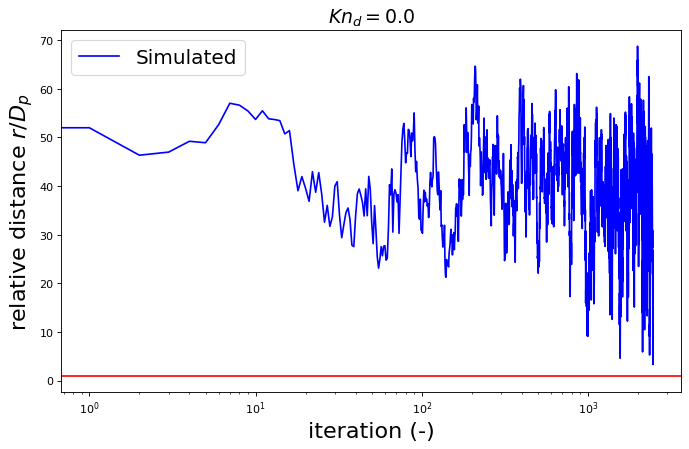

(<matplotlib.legend.Legend at 0x7fde28a19420>, None)

In [19]:
fig, ax1 = plt.subplots(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
plt.axhline(y=1,color="red")
ax1.plot(rel_dist/ftp_model.Rc,"-b",label="Simulated")
title = "$Kn_d=$"+str(round(Kn_d_j[0],2))
plt.title(title,fontsize=17)
plt.xscale("log");
#plt.ylim([0.99*np.mean(dt_vector/tc),1.01*np.mean(dt_vector/tc)]);# plt.xlim([1e-02,1e-01])
ax1.set_ylabel('relative distance $r/D_p$', fontsize=20)
ax1.set_xlabel('iteration (-)', fontsize=20)
plt.legend(fontsize=18, loc=0), plt.show()

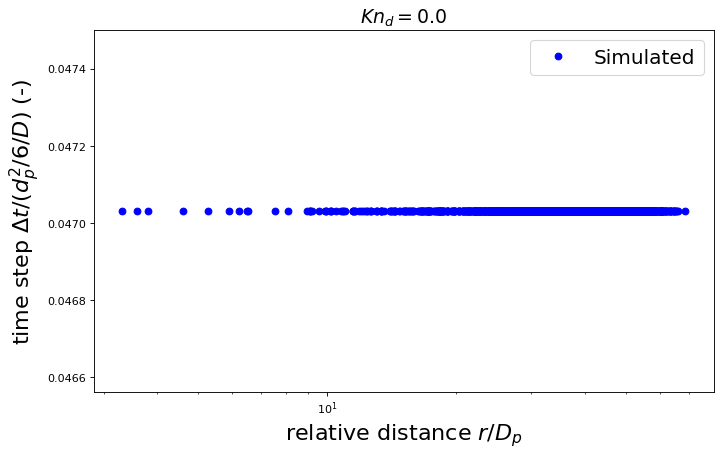

(<matplotlib.legend.Legend at 0x7fde285ebb80>, None)

In [20]:
D = k_BT/ftp_model.f_ij
tc = ftp_model.Rc **2 /(6*D)

fig, ax1 = plt.subplots(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
ax1.plot(rel_dist/ftp_model.Rc, dt_vector/tc,"o b",label="Simulated")
title = "$Kn_d=$"+str(round(Kn_d_j[0],2))
plt.title(title,fontsize=17)
plt.xscale("log");
plt.ylim([0.99*np.mean(dt_vector/tc),1.01*np.mean(dt_vector/tc)]);# plt.xlim([1e-02,1e-01])
ax1.set_xlabel('relative distance $r/D_p$', fontsize=20)
ax1.set_ylabel('time step $\Delta t/(d_p^2/6/D)$ (-)', fontsize=20)
plt.legend(fontsize=18, loc=0), plt.show()

In [ ]:
Kn_d2 = np.logspace(np.log10(1e-02),np.log10(8e+02), 500)
H_theo = ftp_support.H_function(Kn_d2)

H_theo_d = ftp_support.H_diffusive(Kn_d2)
H_theo_b = ftp_support.H_ballistic(Kn_d2)

In [ ]:
# Read Ouyang results
ouyang_res = pd.read_csv('old_results/Ouyang_res.dat', sep='\t')
ouyang_res.head()

In [ ]:
H_no_vdW = ftp_support.H_function(Kn_d_j[0])

H_cont_teo = 4*np.pi * np.power(Kn_d_j[0],2)

In [ ]:
fig, ax1 = plt.subplots(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
ax1.plot(Kn_d_j[0],H[0],"o b",label="Simulated")
ax1.plot(Kn_d_j[0],H_cont_teo,"x k",label="Theoretical H, diffusive")
ax1.plot(Kn_d2, H_theo_d,".-k",label="Theoretical H, diffusive")
ax1.plot(Kn_d2, H_theo,"-c",label="Theoretical H, transition")

title = "$Kn_d=$"+str(round(Kn_d_j[0],2))
plt.title(title,fontsize=17)
plt.xscale("log");
plt.ylim([2e-04,8e-03]); plt.xlim([1e-02,1e-01])
ax1.set_xlabel('Diffusive Knudsen, Kn$_D$ (-)', fontsize=20)
ax1.set_ylabel('Dimensionless coagulation\n kernel $H$ (-)', fontsize=20)
plt.legend(fontsize=18, loc=0), plt.show()

In [ ]:
fig, ax1 = plt.subplots(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
ax1.plot(A/k_BT,H,"o b",label="Simulated")
title = "$Kn_d=$"+str(round(Kn_d_j[0],2))
plt.title(title,fontsize=17)
plt.xscale("log")
ax1.set_xlabel('Hamaker constant, $A/(k_BT)$ (-)', fontsize=20)
ax1.set_ylabel('Dimensionless coagulation\n kernel $H$ (-)', fontsize=20)
plt.legend(fontsize=18, loc=0), plt.show()

fig, ax1 = plt.subplots(num=None, figsize=(10, 6), dpi=80, facecolor='w', edgecolor='k')
plt.rc('xtick', labelsize=17) 
plt.rc('ytick', labelsize=17) 
ax1.plot(ouyang_res["A/(k_b*T)"],ouyang_res["n_C"],"-r", linewidth=2,label="Ouyang et al. 2012 (spheres)")
ax1.plot(A/k_BT,beta_j/beta_j[0],"o b",label="Simulated")
title = "$Kn_d=$"+str(round(Kn_d_j[0],2))
plt.title(title,fontsize=17)
plt.xscale("log")
ax1.set_xlabel('Hamaker constant, $A/(k_BT)$ (-)', fontsize=20)
ax1.set_ylabel('Coagulation enhancement $\eta$ (-)', fontsize=20)
plt.legend(fontsize=18, loc=0), plt.show()